In [1]:
import numpy as np
import pandas as pd

from project.dia_pckg.plot_style.cb91visuals import *
from project.part_2.BiddingEnvironment import BiddingEnvironment
from project.part_2.GPTS_Learner import GPTS_Learner
from project.part_2.Optimizer import *
from project.dia_pckg.Config import *

In [2]:
np.random.seed(88)


bids = np.linspace(0, max_bid, n_arms)
print(bids)

total_click_each_day = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])

noise_std = 6.0
env = BiddingEnvironment(bids,max_clicks,noise_std)

learners = []
for i in range(0, n_subcamp):
    learners.append(GPTS_Learner(n_arms,bids))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[ 4.2 18.7 11.6]
[1.   1.   0.92]
[10.7 12.2 11.8]
[0.64 1.   1.  ]
[ 8.1 10.   9.9]
[0.37 1.   1.  ]


# CLAIRVOYANT REWARD

In [3]:
all_optimal_subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for i in range(0,n_subcamp):
    all_optimal_subs = np.append(all_optimal_subs,np.atleast_2d(env.subs[i].bid(bids)),0)

print(all_optimal_subs)
print(fit_table(all_optimal_subs))
opt = fit_table(all_optimal_subs)[1]

[[  0.  35.  57.  72.  82.  88.  92.  95.  97.  98.  99.]
 [-36.  30.  53.  60.  63.  64.  64.  64.  64.  64.  64.]
 [-63.  -7.  18.  29.  34.  36.  37.  37.  37.  37.  37.]]
([4, 3, 3], 171.0)


# EXPLORATION PHASE

In [4]:
daily_regret = 0

#for i in range(0, n_obs_exploration):

clicks = []

#Pull an arm for each sub-campaign:
#It is pulled the arm belonging to the sub-campaign (i%3) which has the maximum variance
#For the other 2 sub-campaigns the arm is pulled randomly (s.t. the sum = maximum)
### N.B. This behaviour works only for arms linearly distributed  over the array_bids

pulled = [0,0,0]
pulled[0] = 9# learners[first].pull_arm()
pulled[1] = 9#np.random.randint(0,n_arms - pulled[first])
pulled[2] = 9#n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1

clicks = env.round(pulled[0],pulled[1],pulled[2])

for x in range(0,n_subcamp):
    learners[x].update(pulled[x], clicks[x])
# total_click_each_day = total_click_each_day.append({
#     'bid_sub1':pulled[0],
#     'bid_sub2':pulled[1],
#     'bid_sub3':pulled[2],
#     "click1":clicks[0],
#     "click2":clicks[1],
#     "click3":clicks[2]
# }, ignore_index=True)

reward = []

# num_clicks_day_i = total_click_each_day.values[i][3]  \
#                 + total_click_each_day.values[i][4] \
#                 + total_click_each_day.values[i][5]

#reward.append(num_clicks_day_i)

#daily_regret = np.sum(opt - reward)

In [5]:
#print("lAST Regret: ", daily_regret)

print("Days used for exploration: ", n_obs_exploration)
n_obs_exploitation = n_obs - n_obs_exploration

Days used for exploration:  3


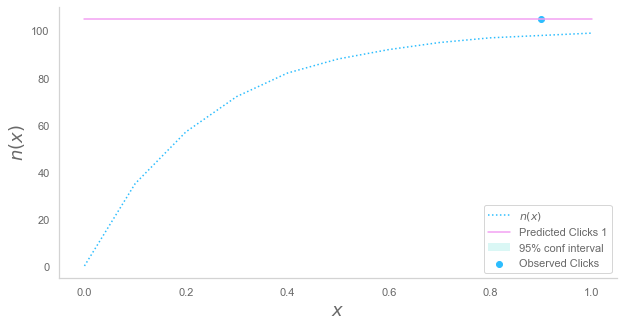

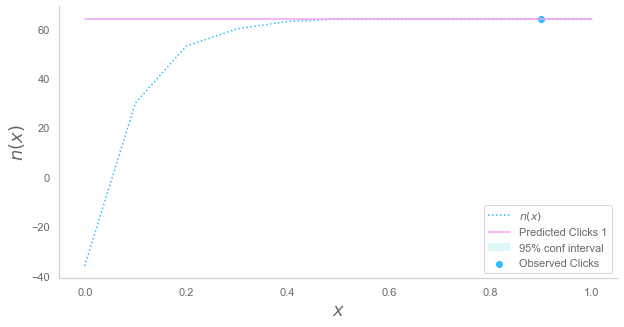

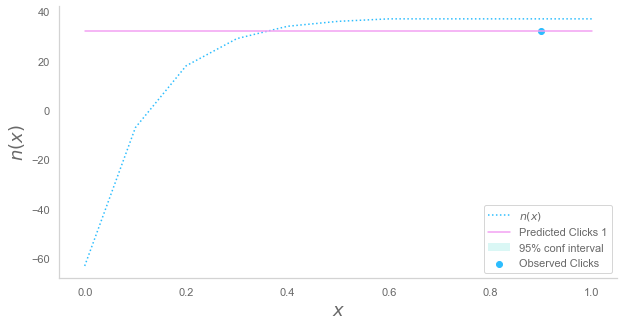

In [6]:
for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s].bid)

In [7]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)
print(fit_table(table_all_Subs))

[[105. 105. 105. 105. 105. 105. 105. 105. 105. 105. 105.]
 [ 64.  64.  64.  64.  64.  64.  64.  64.  64.  64.  64.]
 [ 32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.]]
([10, 0, 0], 201.0)


# EXPLOITATION PHASE

In [8]:
for i in range(0, n_obs_exploitation):
    clicks = []

    pulled = fit_table(table_all_Subs)[0]

    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
    for l in learners:
        table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

/Users/08volt/.conda/envs/DataIntelligenceApplications/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


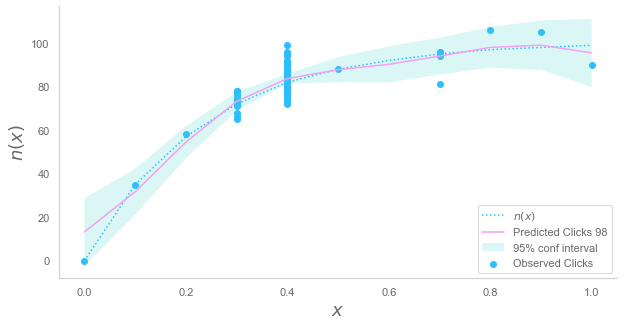

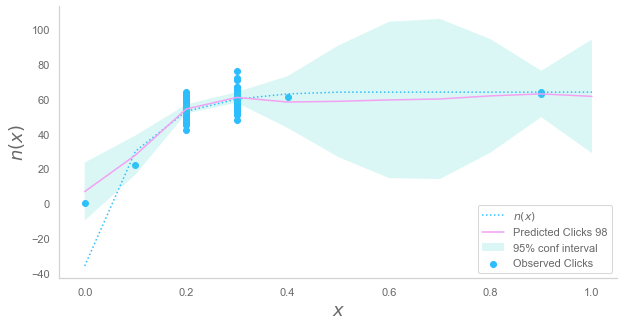

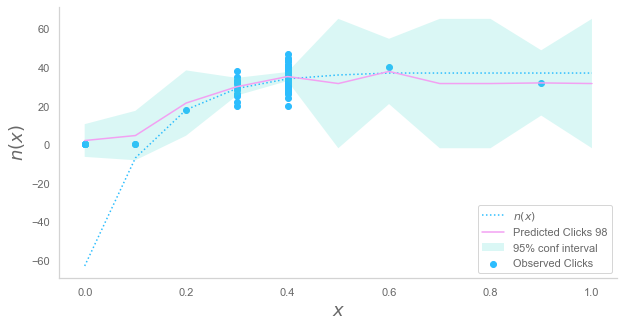

In [9]:
for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s].bid)

In [10]:
print(fit_table(table_all_Subs))

([4, 3, 3], 174.59017469618044)


## Regret Computation


171.0


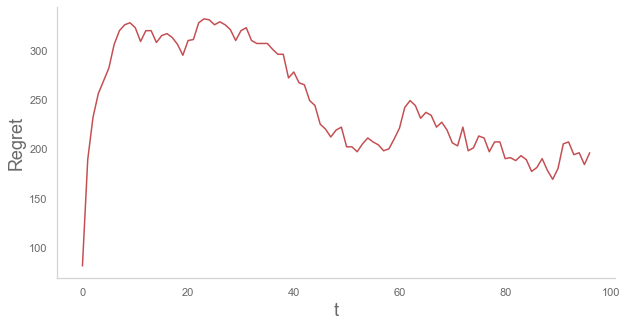

In [11]:
# list of the collected reward
rewards_per_experiment = []
opt = fit_table(all_optimal_subs)[1]
print(opt)

for i in range(0,n_obs_exploitation):
    num_clicks_day_i = total_click_each_day.values[i][3]  \
                       + total_click_each_day.values[i][4] \
                       + total_click_each_day.values[i][5]
    rewards_per_experiment.append(num_clicks_day_i)

plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(opt - rewards_per_experiment, axis=0), 'r')
plt.show()



In [12]:
print(np.sum(rewards_per_experiment))


16391.0
